In [1]:
import pandas as pd
import numpy as np

In [2]:
all_preds = pd.read_csv("predictions/initial_all_preds.csv")
all_preds.head(20)
# all_preds[all_preds["Name"].str.contains("Matt")]

,Rank,Name,Pos,proj_fpoints
0,1.0,Shohei Ohtani,DH,508.527344
1,2.0,Juan Soto,OF,495.032689
2,3.0,Zack Wheeler,SP,485.968383
3,4.0,Tarik Skubal,SP,485.110607
4,5.0,Aaron Judge,OF,478.949651
5,6.0,Bobby Witt Jr.,SS,478.107152
6,7.0,Jose Ramirez,3B,460.083944
7,8.0,Chris Sale,SP,455.391526
8,9.0,Paul Skenes,SP,454.335628
9,10.0,Logan Gilbert,SP,454.323407


In [3]:
## Taking top 400 players - below that are irrelevant
all_preds_400 = all_preds.head(300)

In [4]:
# Exploding all positions:
all_preds_exploded = all_preds.assign(Pos = all_preds["Pos"].str.split("/")).explode("Pos")
all_preds_exploded.loc[:, "Pos"] = all_preds_exploded.loc[:, "Pos"].str.strip()
all_preds_exploded = all_preds_exploded.dropna(subset=['Pos'])
all_preds_exploded["Pos"].unique()

array(['DH', 'OF', 'SP', 'SS', '3B', '1B', '2B', 'RP', 'C'], dtype=object)

In [5]:
## Getting positional average and standard deviation:
# Split positions and explode the dataframe
all_preds_400_exploded = all_preds_400.assign(Pos=all_preds_400['Pos'].str.split('/')).explode('Pos')
all_preds_400_exploded.loc[:, "Pos"] = all_preds_400_exploded.loc[:, "Pos"].str.strip()
all_preds_400_exploded["Pos"].unique()

array(['DH', 'OF', 'SP', 'SS', '3B', '1B', '2B', 'RP', 'C'], dtype=object)

In [6]:
# Calculate mean and standard deviation for each position
pos_stats = all_preds_400_exploded.groupby('Pos')['proj_fpoints'].agg(['mean', 'std']).reset_index()
pos_stats

,Pos,mean,std
0,1B,322.116217,52.852769
1,2B,296.160442,46.739445
2,3B,308.411984,64.004061
3,C,289.196370,30.518661
4,DH,346.544905,119.092538
5,OF,308.809142,62.415301
6,RP,276.259683,39.371023
7,SP,335.029272,62.892789
8,SS,323.558628,61.526180


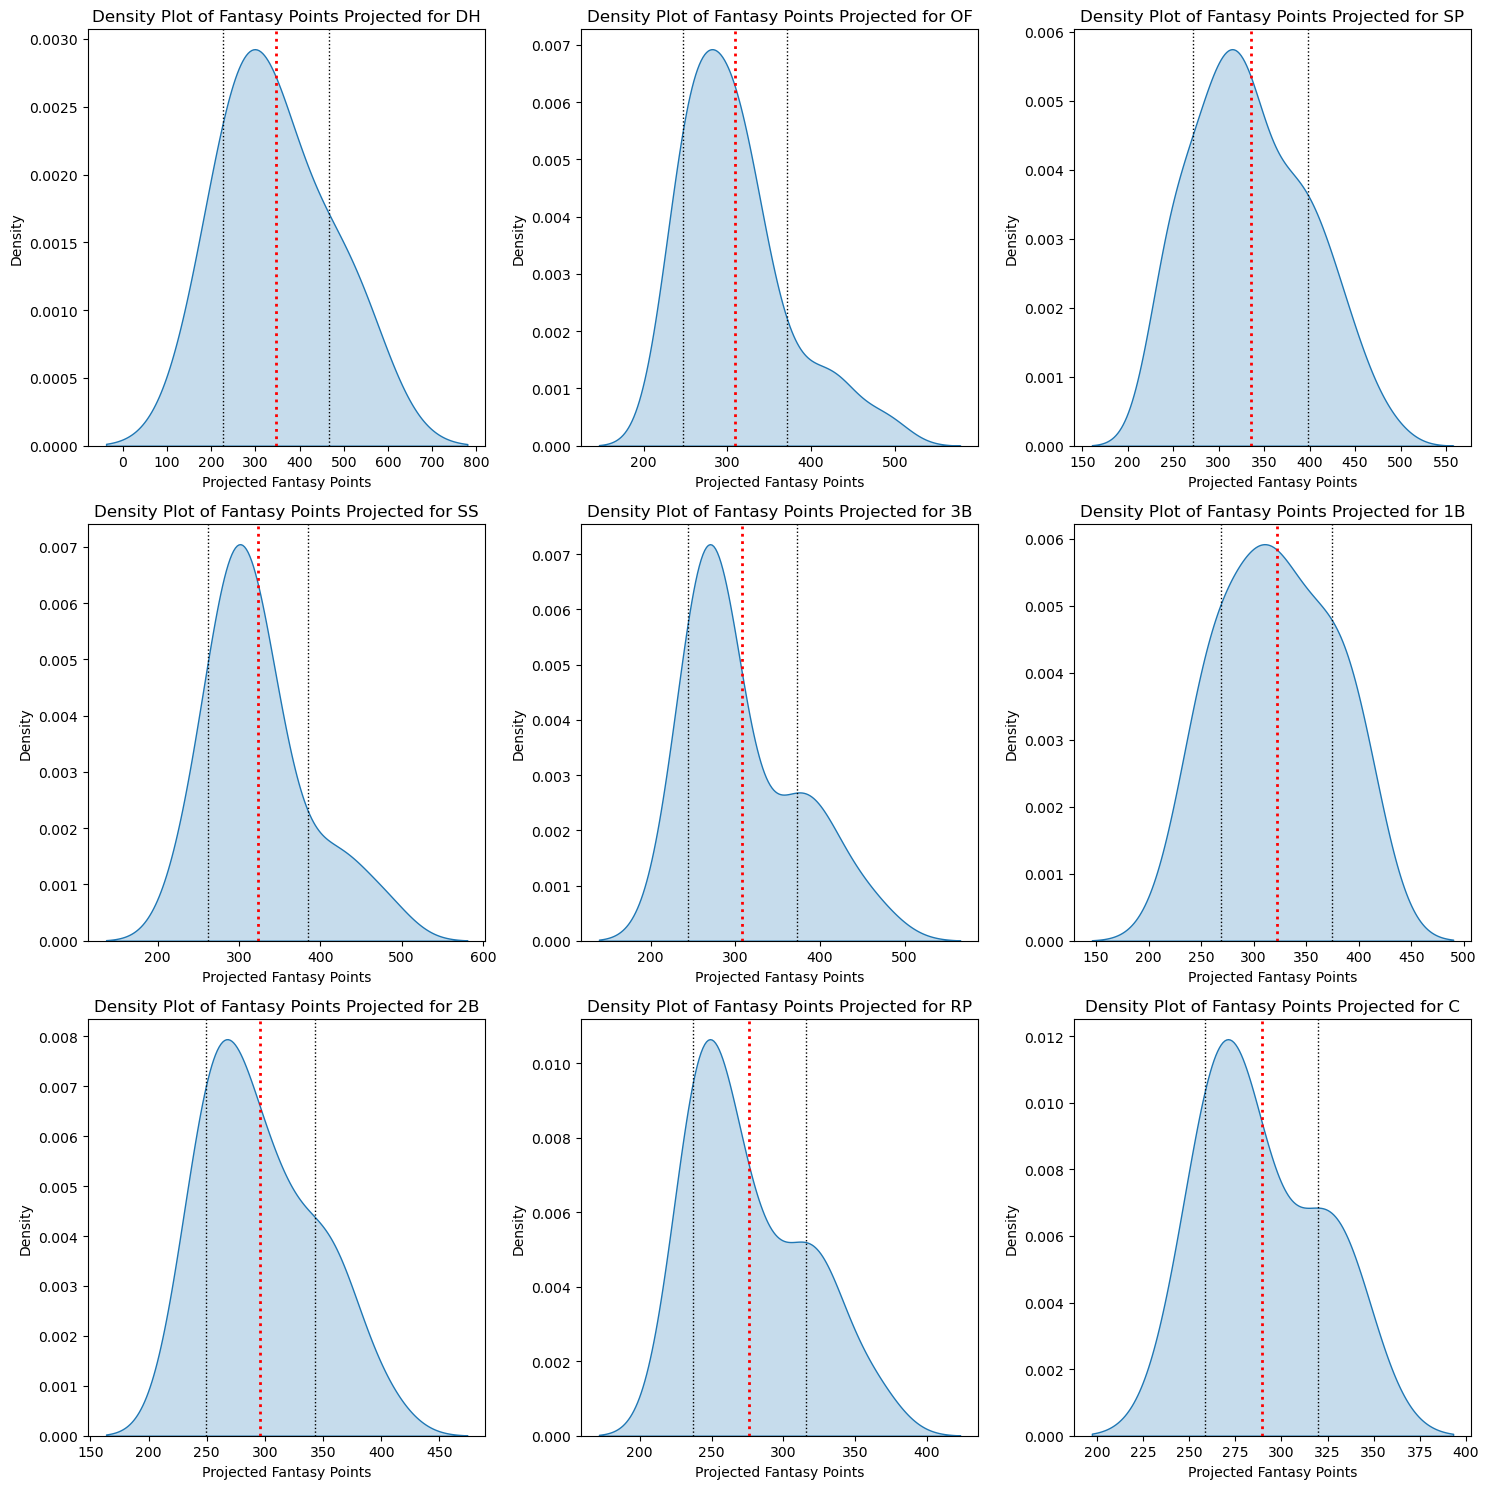

In [7]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

# Get unique positions
positions = all_preds_400_exploded['Pos'].unique()


num_positions = len(positions)
num_cols = 3
num_rows = (num_positions + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, pos in enumerate(positions):
    subset = all_preds_400_exploded[all_preds_400_exploded['Pos'] == pos]
    sns.kdeplot(subset['proj_fpoints'], shade=True, ax=axes[i])
    mean = pos_stats[pos_stats['Pos'] == pos]['mean'].values[0]
    std = pos_stats[pos_stats['Pos'] == pos]['std'].values[0]
    
    axes[i].axvline(mean, color='red', linestyle='dotted', linewidth=2)
    axes[i].axvline(mean + std, color='black', linestyle='dotted', linewidth=1)
    axes[i].axvline(mean - std, color='black', linestyle='dotted', linewidth=1)
    axes[i].set_title(f'Density Plot of Fantasy Points Projected for {pos}')
    axes[i].set_xlabel('Projected Fantasy Points')
    axes[i].set_ylabel('Density')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
# plt.savefig("figures/position_density_plots.png")

In [8]:
## Calculating positional adjustment:

pos_stats['pos_adj'] = (((pos_stats['mean'] - pos_stats['mean'].mean()) / pos_stats['std']) * all_preds_400['proj_fpoints'].std()) * 0.5
pos_stats


,Pos,mean,std,pos_adj
0,1B,322.116217,52.852769,6.087865
1,2B,296.160442,46.739445,-10.415340
2,3B,308.411984,64.004061,-1.642868
3,C,289.196370,30.518661,-23.059668
4,DH,346.544905,119.092538,9.091727
5,OF,308.809142,62.415301,-1.486464
6,RP,276.259683,39.371023,-28.110791
7,SP,335.029272,62.892789,11.512047
8,SS,323.558628,61.526180,5.959969


In [9]:
## Including roster contstraints:
num_c = 1.5
num_2b = 1.5
num_1b = 1.5
num_3b = 1.5
num_ss = 1.5
num_of = 0.9
num_rp = 1.5
num_sp = 0.5
## Making DH a higher value since it is restriced to UTIL
## This will lower the positional adjustment
num_dh = 0.5
# Find the maximum number of players for any position
num_max = max(num_c, num_2b, num_1b, num_3b, num_ss, num_of, num_rp, num_sp, num_dh)

# Create a dictionary for the number of players per position
num_dict = {
    'C': num_c,
    '2B': num_2b,
    '1B': num_1b,
    '3B': num_3b,
    'SS': num_ss,
    'OF': num_of,
    'RP': num_rp,
    'SP': num_sp,
    'DH': num_dh
}

# Apply the adjustment to pos_stats
pos_stats['pos_adj'] = pos_stats.apply(lambda row: row['pos_adj'] * num_max / num_dict[row['Pos']], axis=1)
pos_stats

,Pos,mean,std,pos_adj
0,1B,322.116217,52.852769,6.087865
1,2B,296.160442,46.739445,-10.415340
2,3B,308.411984,64.004061,-1.642868
3,C,289.196370,30.518661,-23.059668
4,DH,346.544905,119.092538,27.275181
5,OF,308.809142,62.415301,-2.477440
6,RP,276.259683,39.371023,-28.110791
7,SP,335.029272,62.892789,34.536142
8,SS,323.558628,61.526180,5.959969


In [10]:
pos_stats.loc[pos_stats['Pos'] == 'C', 'pos_adj'] *= 1.5
pos_stats

,Pos,mean,std,pos_adj
0,1B,322.116217,52.852769,6.087865
1,2B,296.160442,46.739445,-10.415340
2,3B,308.411984,64.004061,-1.642868
3,C,289.196370,30.518661,-34.589502
4,DH,346.544905,119.092538,27.275181
5,OF,308.809142,62.415301,-2.477440
6,RP,276.259683,39.371023,-28.110791
7,SP,335.029272,62.892789,34.536142
8,SS,323.558628,61.526180,5.959969


In [11]:
# Calculate the mean of all batting positions
batting_positions = pos_stats[~pos_stats['Pos'].isin(['RP', 'SP'])]
mean_batting = batting_positions['mean'].mean()

# Calculate the difference between the mean of SP and the mean of all batting positions
mean_sp = pos_stats[pos_stats['Pos'] == 'SP']['mean'].values[0]
difference = mean_sp - mean_batting

# Increase the pos_adj for SP by the calculated difference
pos_stats.loc[pos_stats['Pos'] == 'SP', 'pos_adj'] += difference

# Reducing RP adjustment by the difference - as RP should also take a hit compared to batter
pos_stats.loc[pos_stats['Pos'] == 'RP', 'pos_adj'] += (difference)

pos_stats

,Pos,mean,std,pos_adj
0,1B,322.116217,52.852769,6.087865
1,2B,296.160442,46.739445,-10.415340
2,3B,308.411984,64.004061,-1.642868
3,C,289.196370,30.518661,-34.589502
4,DH,346.544905,119.092538,27.275181
5,OF,308.809142,62.415301,-2.477440
6,RP,276.259683,39.371023,-6.624046
7,SP,335.029272,62.892789,56.022887
8,SS,323.558628,61.526180,5.959969


In [12]:
pos_merged = all_preds_exploded.merge(pos_stats, on='Pos', how='left')
pos_merged.head(30)
pos_merged[pos_merged["Name"].str.contains("Matt")]

,Rank,Name,Pos,proj_fpoints,mean,std,pos_adj
52,51.0,Matt Olson,1B,380.037574,322.116217,52.852769,6.087865
144,141.0,Matthew Boyd,SP,310.445061,335.029272,62.892789,56.022887
228,216.0,Matt Chapman,3B,269.766249,308.411984,64.004061,-1.642868
352,336.0,Matt McLain,2B,216.468299,296.160442,46.739445,-10.415340
353,336.0,Matt McLain,SS,216.468299,323.558628,61.526180,5.959969
409,392.0,Matt Vierling,3B,195.703536,308.411984,64.004061,-1.642868
410,392.0,Matt Vierling,OF,195.703536,308.809142,62.415301,-2.477440
465,444.0,Matt Strahm,RP,182.768034,276.259683,39.371023,-6.624046
478,454.0,Matt Wallner,OF,181.253764,308.809142,62.415301,-2.477440
561,531.0,Matt Brash,RP,160.839842,276.259683,39.371023,-6.624046


In [13]:
# Group by 'Name' and aggregate 'Pos' and 'pos_adj'
combined_pos_merged = pos_merged.groupby('Name').agg({
    'Pos': lambda x: '/'.join(sorted(x)),
    'pos_adj': 'min',
    'Rank': 'first',
    'proj_fpoints': 'first',
    'mean': 'first',
    'std': 'first'
}).reset_index()

combined_pos_merged.sort_values(by = 'proj_fpoints', ascending = False).head(30)

,Name,Pos,pos_adj,Rank,proj_fpoints,mean,std
989,Shohei Ohtani,DH/SP,27.275181,1.0,508.527344,346.544905,119.092538
612,Juan Soto,OF,-2.477440,2.0,495.032689,308.809142,62.415301
1155,Zack Wheeler,SP,56.022887,3.0,485.968383,335.029272,62.892789
1020,Tarik Skubal,SP,56.022887,4.0,485.110607,335.029272,62.892789
6,Aaron Judge,OF,-2.477440,5.0,478.949651,308.809142,62.415301
107,Bobby Witt Jr.,SS,5.959969,6.0,478.107152,323.558628,61.526180
593,Jose Ramirez,3B,-1.642868,7.0,460.083944,308.411984,64.004061
205,Chris Sale,SP,56.022887,8.0,455.391526,335.029272,62.892789
871,Paul Skenes,SP,56.022887,9.0,454.335628,335.029272,62.892789
695,Logan Gilbert,SP,56.022887,10.0,454.323407,335.029272,62.892789


In [14]:
# Define the positions for which we need to subtract 10 or 20 from pos_adj
multi_pos_10 = {'1B', '2B', '3B', 'SS', 'OF'}
multi_pos_20 = {'C'}

# Function to adjust pos_adj based on multiple positions
def adjust_pos_adj(row):
    positions = set(row['Pos'].split('/'))
    if len(positions) > 1:
        if positions & multi_pos_20:
            return row['pos_adj'] - 20
        elif positions & multi_pos_10:
            return row['pos_adj'] - 5
    return row['pos_adj']

# Apply the adjustment
combined_pos_merged['pos_adj'] = combined_pos_merged.apply(adjust_pos_adj, axis=1)
combined_pos_merged.sort_values(by = 'proj_fpoints', ascending = False).head(40)

,Name,Pos,pos_adj,Rank,proj_fpoints,mean,std
989,Shohei Ohtani,DH/SP,27.275181,1.0,508.527344,346.544905,119.092538
612,Juan Soto,OF,-2.477440,2.0,495.032689,308.809142,62.415301
1155,Zack Wheeler,SP,56.022887,3.0,485.968383,335.029272,62.892789
1020,Tarik Skubal,SP,56.022887,4.0,485.110607,335.029272,62.892789
6,Aaron Judge,OF,-2.477440,5.0,478.949651,308.809142,62.415301
107,Bobby Witt Jr.,SS,5.959969,6.0,478.107152,323.558628,61.526180
593,Jose Ramirez,3B,-1.642868,7.0,460.083944,308.411984,64.004061
205,Chris Sale,SP,56.022887,8.0,455.391526,335.029272,62.892789
871,Paul Skenes,SP,56.022887,9.0,454.335628,335.029272,62.892789
695,Logan Gilbert,SP,56.022887,10.0,454.323407,335.029272,62.892789


In [15]:
combined_pos_merged['Fantasy Points Adjusted'] = combined_pos_merged['proj_fpoints'] - combined_pos_merged['pos_adj']
full_rankings = combined_pos_merged[["Fantasy Points Adjusted", "Name", "Pos", 'proj_fpoints']]
full_rankings['Rank'] = full_rankings['Fantasy Points Adjusted'].rank(ascending=False)
full_rankings.set_index('Rank', inplace=True)
full_rankings=full_rankings.drop(columns = ["Fantasy Points Adjusted"])
full_rankings.sort_values(by = 'Rank', ascending = True).head(50)
full_rankings[full_rankings["Name"].str.contains("Diaz")]

,Name,Pos,proj_fpoints
Rank,,,
989.0,Aledmys Diaz,3B/SS,44.613135
229.0,Alexis Diaz,RP,245.245377
86.0,Edwin Diaz,RP,321.829429
724.0,Elias Diaz,C,82.678893
1156.0,Jhonathan Diaz,SP,7.583250
228.0,Yainer Diaz,C,217.470573
59.0,Yandy Diaz,1B,355.874173
780.0,Yilber Diaz,RP,96.968270


In [17]:
full_rankings.sort_values(by = 'Rank', ascending = True).to_csv("predictions/full_ranks.csv")